In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

import re 
import nltk 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.model_selection import train_test_split
from time import time

import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from matplotlib import pyplot as plt
import pandas as pd
import io
from sklearn.metrics import classification_report
import pickle

In [1]:
import pandas as pd

def performDataFrameManipulation():
    file_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\Cyberbullying_Dataset_English_Hinglish.xlsx"
    df = pd.read_excel(file_path)

    if "LABEL" in df.columns:
        df["LABEL"] = df["LABEL"].replace(-1, 1)
    else:
        print("Error: 'LABEL' column not found in the dataset.")

    return df

df = performDataFrameManipulation()
df.head()

,COMMENT,LANGUAGE,LABEL
0,mere timer ko roko,HINGLISH,0
1,Kya hawaii me raining ho rahi hai?,HINGLISH,0
2,Mere liye reminder set karo to wake up at 6:30...,HINGLISH,0
3,Please timer ko rokey,HINGLISH,0
4,Killswitch engaged ka pehla album play kariye,HINGLISH,0


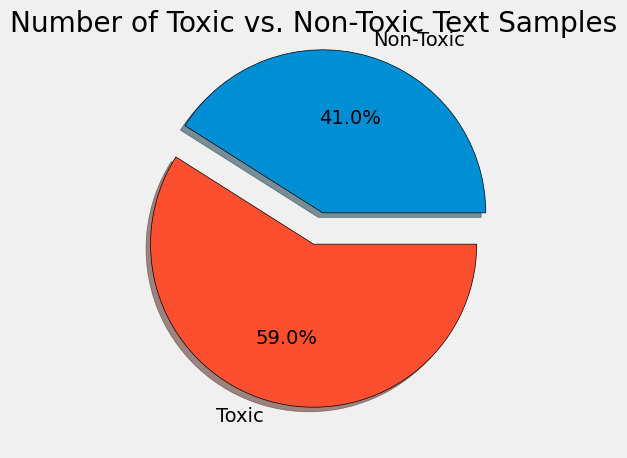

In [3]:
import matplotlib.pyplot as plt

def performDataDistribution(df):
  plt.style.use('fivethirtyeight')

  tot = df.shape[0]
  num_non_toxic = df[df.LABEL==0].shape[0]
  slices = [num_non_toxic/tot,(tot - num_non_toxic)/tot]
  labeling = ['Non-Toxic','Toxic']
  explode = [0.2,0]
  plt.pie(slices,explode=explode,shadow=True,autopct='%1.1f%%',labels=labeling,wedgeprops={'edgecolor':'black'})
  plt.title('Number of Toxic vs. Non-Toxic Text Samples')
  plt.tight_layout()
  plt.show()

performDataDistribution(df)

In [4]:
def remove_pattern(input_txt,pattern):
  if(type(input_txt)==str):
    r= re.findall(pattern,input_txt)
    for i in r:
      input_txt = re.sub(i,'',input_txt)
    return input_txt
  else:
    return ""

In [7]:
import numpy as np
import pandas as pd
import nltk
import re


def performDataSetCleaning(df):
  df['COMMENT'].dtype
  df['length_comment'] = df['COMMENT'].str.len()
  combi = pd.concat([df, df], ignore_index=True)

  combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['COMMENT'],"@[\w]*")
  combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-z#]"," ")
  combi['tidy_tweet']= combi['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))

  combi['length_tidy_tweet'] = combi['tidy_tweet'].str.len()

  tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())

  nltk.download('wordnet')
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

  for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
  combi['tidy_tweet'] = tokenized_tweet

  return combi,df

combi,df=performDataSetCleaning(df)  
combi.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ambika\AppData\Roaming\nltk_data...


,COMMENT,LANGUAGE,LABEL,length_comment,tidy_tweet,length_tidy_tweet
0,mere timer ko roko,HINGLISH,0,18,mere timer roko,15
1,Kya hawaii me raining ho rahi hai?,HINGLISH,0,34,hawaii raining rahi hai?,24
2,Mere liye reminder set karo to wake up at 6:30...,HINGLISH,0,59,Mere liye reminder karo wake 6:30 tomorrow.,43
3,Please timer ko rokey,HINGLISH,0,21,Please timer rokey,18
4,Killswitch engaged ka pehla album play kariye,HINGLISH,0,45,Killswitch engaged pehla album play kariye,42


In [ ]:
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


def performTestDataSplitting(x,y,combi,df):
  X_train, X_test,y_train,y_test = train_test_split(combi['tidy_tweet'], 
                                                    combi['LABEL'], 
                                                    test_size=0.33, 
                                                    random_state=42, 
                                                    stratify=combi['LABEL'])
  print('Number of rows in the total set: {}'.format(combi.shape[0]))
  print('Number of rows in the training set: {}'.format(X_train.shape[0]))
  print('Number of rows in the test set: {}'.format(X_test.shape[0]))

  my_file = open(r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\stopwords.txt", "r")
  content = my_file.read()
  content_list = content.split("\n")
  my_file.close()

  tfidf_vector = TfidfVectorizer(stop_words = content_list ,lowercase = True)

  training_data = tfidf_vector.fit_transform(X_train.values.astype('U'))
  print(X_train.shape)
  print(training_data.shape)

  testing_data = tfidf_vector.transform(X_test.values.astype('U'))

  filename = 'tfidf_vector_vocabulary.pkl'
  pickle.dump(tfidf_vector.vocabulary_, open(filename, 'wb'))

  return X_train,X_test,y_train,y_test,testing_data,filename,training_data,content_list

x_train,x_test,y_train,y_test,testing_data,filename,training_data,content_list = performTestDataSplitting(0.33,42,combi,df)

Number of rows in the total set: 35006
Number of rows in the training set: 23454
Number of rows in the test set: 11552
(23454,)
(23454, 13816)


In [15]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from time import time
import pickle

def pipeline(X_train, y_train, X_test, y_test): 

    learner_list = [LinearSVC(),RandomForestClassifier(),LogisticRegression(),KNeighborsClassifier()]
    size = len(y_train)
    
    results = {}
    final_results = []

    for learner in learner_list:
        
        print(learner)
        results['Algorithm'] = learner.__class__.__name__

        start = time()
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time()


        filename = learner.__class__.__name__+".pkl"
        pickle.dump(learner, open(filename, 'wb'))


        results['Training Time'] = end - start

        start = time()
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time()

        results['Prediction Time'] = end - start

        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        results['Precision: Test'] = precision_score(y_test, predictions_test)

        results['Precision: Train'] = precision_score(y_train, predictions_train)

        results['Recall: Test'] = recall_score(y_test, predictions_test)

        results['Recall: Train'] = recall_score(y_train, predictions_train)

        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    return final_results

final_results=pipeline(training_data,y_train,testing_data,y_test)

LinearSVC()
Training LinearSVC
Training LinearSVC finished in 0.15 sec
----------------------------------------------------
RandomForestClassifier()
Training RandomForestClassifier
Training RandomForestClassifier finished in 7.76 sec
----------------------------------------------------
LogisticRegression()
Training LogisticRegression
Training LogisticRegression finished in 0.11 sec
----------------------------------------------------
KNeighborsClassifier()
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.00 sec
----------------------------------------------------


In [16]:
def performFinalResults(final_results):
  results = pd.DataFrame(final_results)
  results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

  results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

  return results

results=performFinalResults(final_results)
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,LinearSVC,0.988573,0.985591,0.995343,0.990443,0.001992,0.996077,0.994650,0.998693,0.996668,0.146945
1,RandomForestClassifier,0.986842,0.982759,0.995343,0.989011,2.018330,0.996589,0.994655,0.999564,0.997104,7.756038
2,LogisticRegression,0.976801,0.966252,0.995780,0.980794,0.002006,0.987891,0.982339,0.997314,0.989770,0.106519
3,KNeighborsClassifier,0.873442,0.870142,0.925349,0.896897,12.917858,0.932762,0.923312,0.965738,0.944048,0.000981


In [17]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.873442,0.870142,0.925349,0.896897,0.001992,0.932762,0.923312,0.965738,0.944048,0.000981
max,0.988573,0.985591,0.995780,0.990443,12.917858,0.996589,0.994655,0.999564,0.997104,7.756038


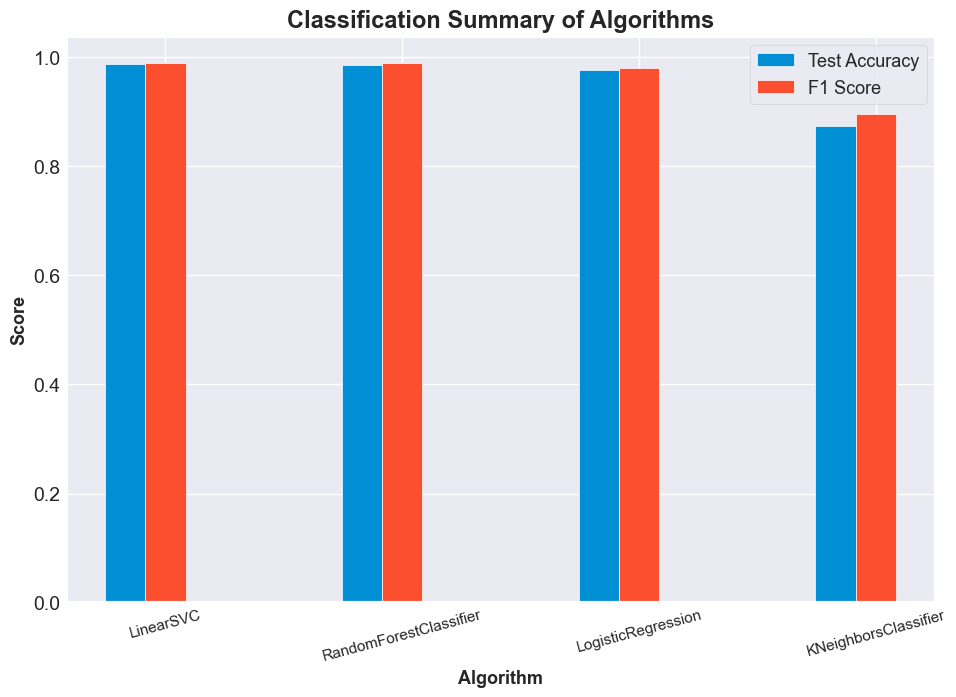

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('darkgrid')
plt.figure(figsize = (10, 7))

barWidth = 0.17
 
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')

plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

plt.legend(fontsize = 13)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

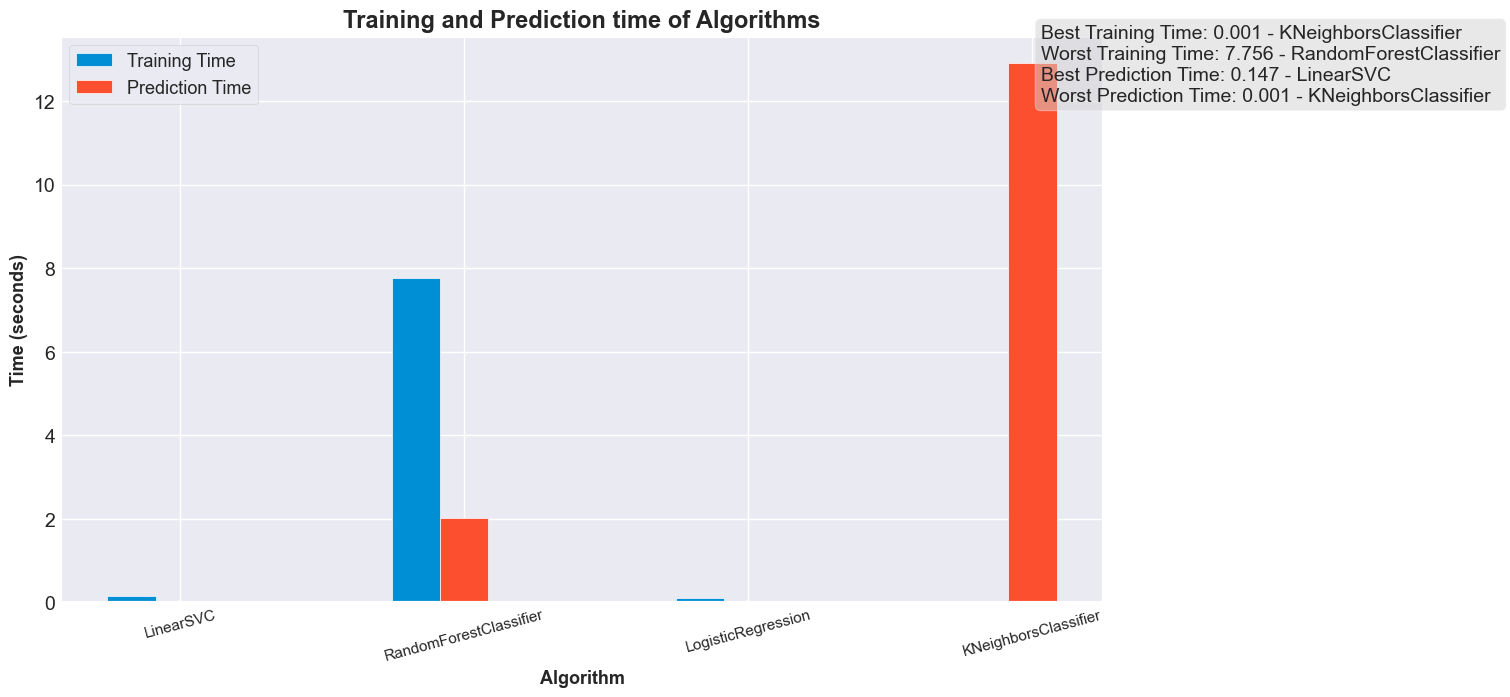

In [20]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle  # Ensure pickle is also imported

vocab_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\tfidf_vector_vocabulary.pkl"
model_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\LinearSVC.pkl"

data = ["are you a moron"]
count_vector = CountVectorizer(stop_words= 'english', lowercase = True,vocabulary=pickle.load(open(vocab_path, "rb")))
data= count_vector.fit_transform(data)

trained_model=pickle.load(open(model_path, 'rb'))
print(trained_model.coef_.shape)

print(trained_model.predict(data))
if(trained_model.predict(data)==1):
  print('bullying')
else:
  print('non-bullying')

(1, 13816)
[1]
bullying


In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle  # Ensure pickle is also imported

vocab_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\tfidf_vector_vocabulary.pkl"
model_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\LinearSVC.pkl"

data = ["chutiya hai kya"]
count_vector = CountVectorizer(stop_words= 'english', lowercase = True,vocabulary=pickle.load(open(vocab_path, "rb")))
data= count_vector.fit_transform(data)

trained_model=pickle.load(open(model_path, 'rb'))
print(trained_model.coef_.shape)

print(trained_model.predict(data))
if(trained_model.predict(data)==1):
  print('bullying')
else:
  print('non-bullying')

(1, 13816)
[1]
bullying


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle  # Ensure pickle is also imported

vocab_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\tfidf_vector_vocabulary.pkl"
model_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\LinearSVC.pkl"

data = ["hutt bc lodu"]
count_vector = CountVectorizer(stop_words= 'english', lowercase = True,vocabulary=pickle.load(open(vocab_path, "rb")))
data= count_vector.fit_transform(data)

trained_model=pickle.load(open(model_path, 'rb'))
print(trained_model.coef_.shape)

print(trained_model.predict(data))
if(trained_model.predict(data)==1):
  print('bullying')
else:
  print('non-bullying')

(1, 13816)
[1]
bullying


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle  # Ensure pickle is also imported

vocab_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\tfidf_vector_vocabulary.pkl"
model_path = r"C:\Users\Ambika\OneDrive\Desktop\dsw\comments\LinearSVC.pkl"

data = ["how are you"]
count_vector = CountVectorizer(stop_words= 'english', lowercase = True,vocabulary=pickle.load(open(vocab_path, "rb")))
data= count_vector.fit_transform(data)

trained_model=pickle.load(open(model_path, 'rb'))
print(trained_model.coef_.shape)

print(trained_model.predict(data))
if(trained_model.predict(data)==1):
  print('bullying')
else:
  print('non-bullying')

(1, 13816)
[1]
bullying


In [34]:
print(df['LABEL'].value_counts())


LABEL
1    10324
0     7179
Name: count, dtype: int64
